In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
import seaborn as sns
from itertools import product

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


In [4]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [5]:
train = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv')

In [6]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

## EDA

We basically have 4 dimensions under which we need to explore the data:
* time
* country
* store
* product

Given the categorical nature of the data, the most obvious would be to have a time series plot of each product's sales for each location (country + store) so 12 plots in total with 4 lines on each.

In [7]:
train

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...,...
70123,70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158
70126,70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135


In [8]:
train.describe()

,row_id,num_sold
count,70128.000000,70128.000000
mean,35063.500000,194.296986
std,20244.354176,126.893874
min,0.000000,19.000000
25%,17531.750000,95.000000
50%,35063.500000,148.000000
75%,52595.250000,283.000000
max,70127.000000,986.000000


In [9]:
test.describe()

,row_id
count,17520.000000
mean,78887.500000
std,5057.732694
min,70128.000000
25%,74507.750000
50%,78887.500000
75%,83267.250000
max,87647.000000


In [10]:
test.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


#### Checking if any NA

In [11]:
train.isna().sum()

row_id      0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [12]:
test.isna().sum()

row_id     0
date       0
country    0
store      0
product    0
dtype: int64

#### Checking categorical unique values

In [13]:
print(train['product'].unique())

['Kaggle Advanced Techniques' 'Kaggle Getting Started'
 'Kaggle Recipe Book' 'Kaggle for Kids: One Smart Goose']


In [14]:
print(test['product'].unique())

['Kaggle Advanced Techniques' 'Kaggle Getting Started'
 'Kaggle Recipe Book' 'Kaggle for Kids: One Smart Goose']


In [15]:
print(train['country'].unique())

['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain']


In [16]:
print(test['country'].unique())

['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain']


In [17]:
print(train['store'].unique())

['KaggleMart' 'KaggleRama']


In [18]:
print(test['store'].unique())

['KaggleMart' 'KaggleRama']


In [19]:
train['product'].unique()

array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
      dtype=object)

In [20]:
train.loc[train['product']=='Kaggle Advanced Techniques','product'] = 'A'
train.loc[train['product']=='Kaggle Getting Started','product'] = 'B'
train.loc[train['product']=='Kaggle Recipe Book','product'] = 'C'
train.loc[train['product']=='Kaggle for Kids: One Smart Goose','product'] = 'D'

In [51]:
test.loc[test['product']=='Kaggle Advanced Techniques','product'] = 'A'
test.loc[test['product']=='Kaggle Getting Started','product'] = 'B'
test.loc[test['product']=='Kaggle Recipe Book','product'] = 'C'
test.loc[test['product']=='Kaggle for Kids: One Smart Goose','product'] = 'D'

In [21]:
prods = train['product'].unique()
countries = train['country'].unique()
stores = train['store'].unique()

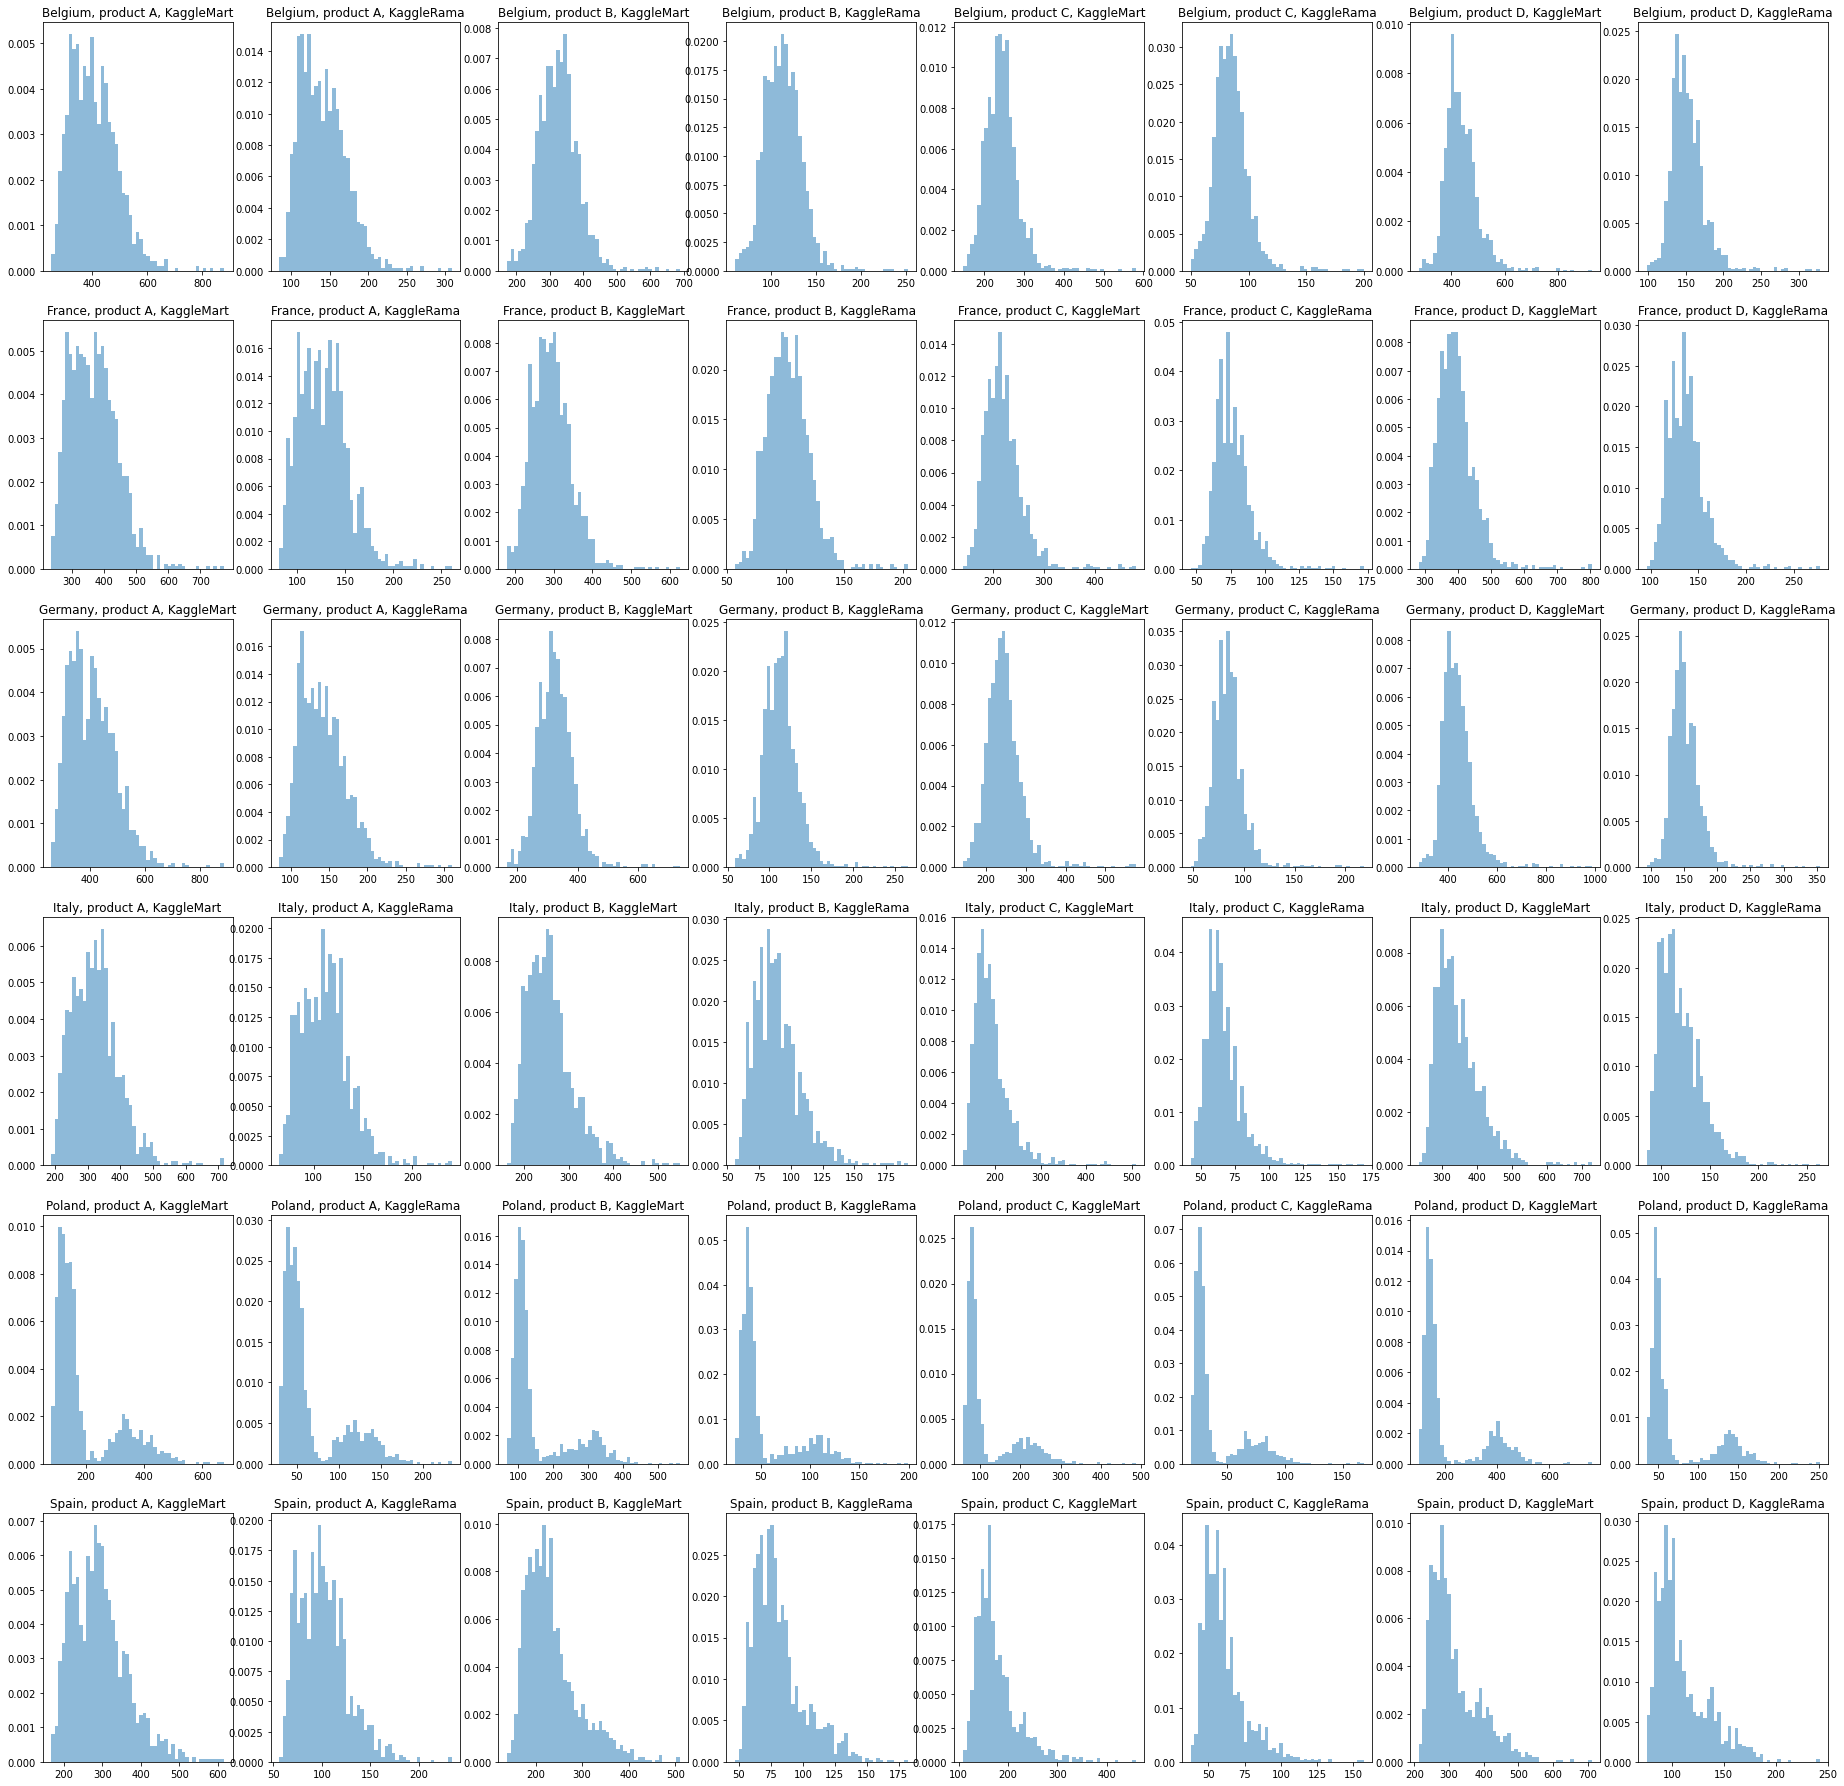

In [22]:
all_combinations = [x for x in product(countries, prods, stores)]

_, axs = plt.subplots(6,8, figsize=(32,32))

for x, ax in zip(all_combinations, axs.ravel()):
    tmp_train = train[(train['country'] == x[0]) & (train['product'] == x[1]) & (train['store'] == x[2])]

    mi = tmp_train['num_sold'].min()
    ma = tmp_train['num_sold'].max()
    bins = np.linspace(mi, ma, 50)
    ax.hist(tmp_train['num_sold'], bins=bins, alpha=0.5, density=True, label='train')
#     ax.set_ylabel(x[0])
    ax.set_title('{c}, product {p}, {s}'.format(c=x[0], p=x[1], s=x[2]))
    
plt.show()

In [23]:
train.dtypes

row_id               int64
date        datetime64[ns]
country             object
store               object
product             object
num_sold             int64
dtype: object

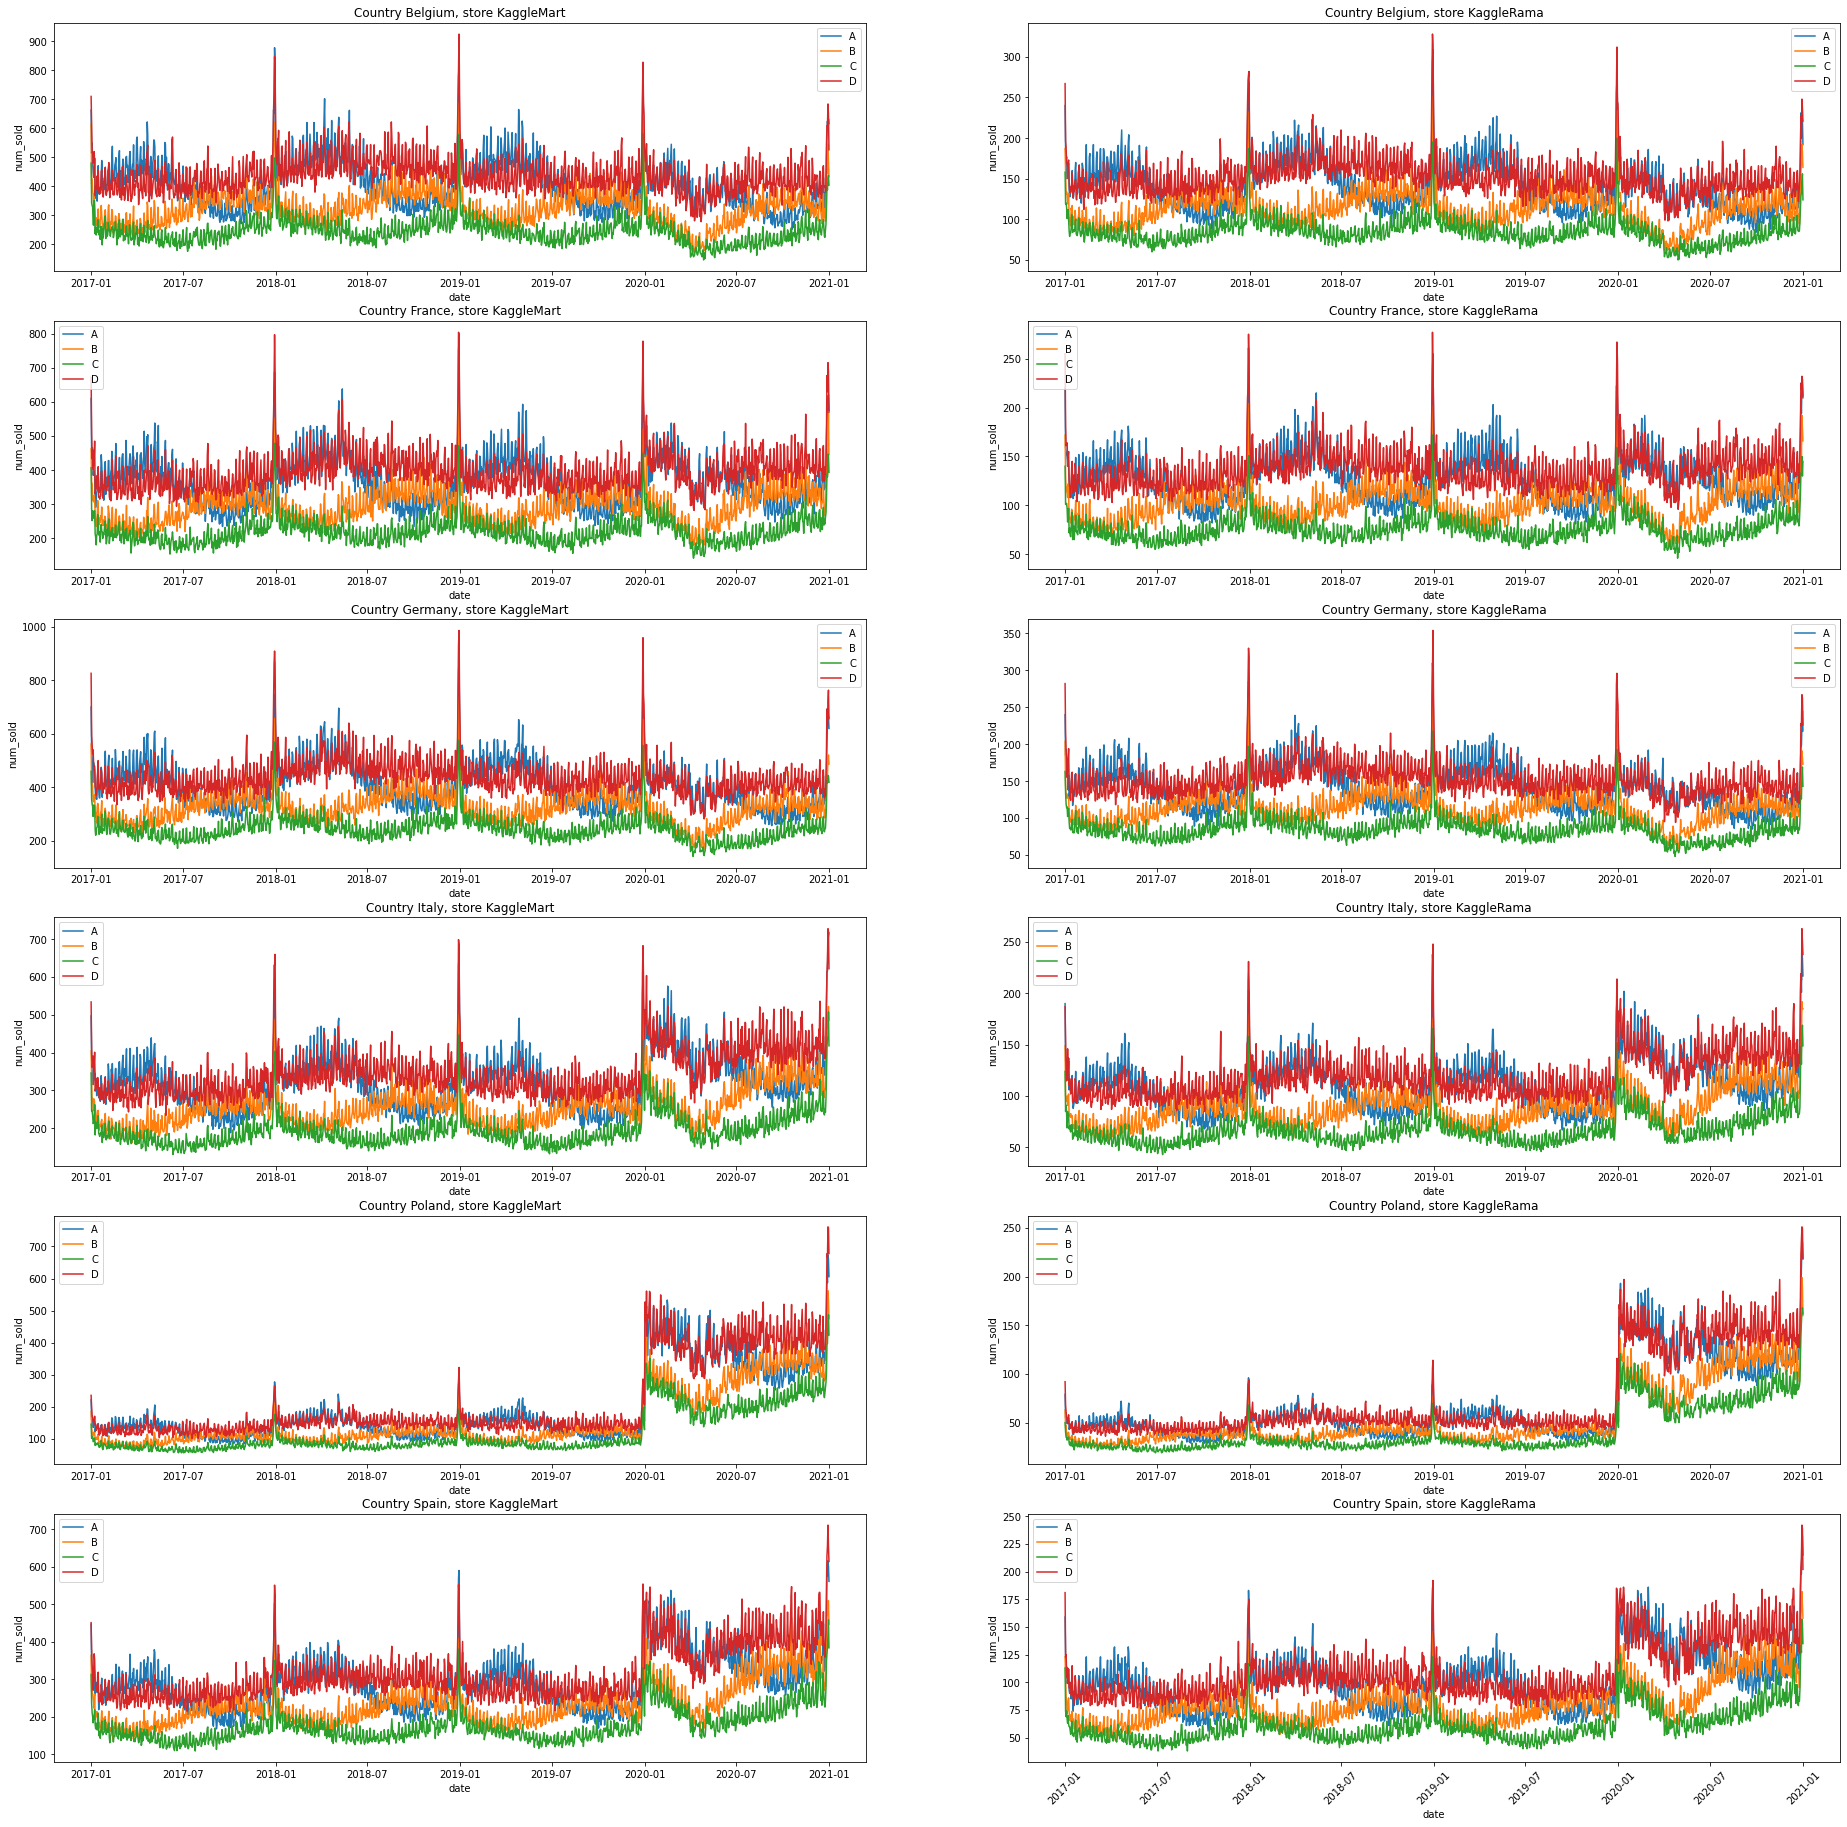

In [24]:
_, axs = plt.subplots(6,2, figsize=(32,32))

for x, ax in zip([x for x in product(countries, stores)], axs.ravel()):

    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'A') & (train['store'] == x[1]) & (train['country'] == x[0])], label="A",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'B') & (train['store'] == x[1]) & (train['country'] == x[0])], label="B",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'C') & (train['store'] == x[1]) & (train['country'] == x[0])], label="C",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'D') & (train['store'] == x[1]) & (train['country'] == x[0])], label="D",ax=ax)
    ax.set_title('Country {c}, store {s}'.format(c=x[0], s=x[1]))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

## Modelling 

* SARIMA
* Create day of the week and months features to capture seasonality 

### Feature engineering

In [25]:
train['weekday'] = train['date'].apply(lambda x: x.weekday())
train['month'] = train['date'].apply(lambda x: x.month)

test['weekday'] = test['date'].apply(lambda x: x.weekday())
test['month'] = test['date'].apply(lambda x: x.month)

In [28]:
X = df[["country","product","weekday","month", "rolling_ave"]]
y = df["num_sold"]

categorical_features = ["country","product","weekday","month"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingRegressor())]
)

tscv = TimeSeriesSplit()

for train_idx, test_idx in tscv.split(X):
    clf.fit(X.iloc[train_idx], y.iloc[train_idx])
    print("model score: %.3f" % clf.score(X.iloc[test_idx], y.iloc[test_idx]))

model score: 0.281
model score: 0.550
model score: 0.822
model score: -0.170
model score: -0.130


In [45]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in parameters_list:
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['params', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [30]:
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 30
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

16


In [31]:
result_df = optimize_SARIMA(parameters_list, 1, 0, 30,df['num_sold'])
result_df

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)x(P,Q)",AIC
0,"(1, 1, 1, 1)",14803.745978
1,"(1, 1, 0, 1)",14812.890262
2,"(1, 1, 1, 0)",14823.396156
3,"(1, 1, 0, 0)",14851.227249
4,"(0, 1, 1, 1)",14978.607702
5,"(0, 1, 0, 1)",14989.775687
6,"(1, 0, 1, 1)",14998.865993
7,"(1, 0, 0, 1)",15007.361375
8,"(0, 1, 1, 0)",15015.500251
9,"(1, 0, 1, 0)",15029.354356


In [32]:
result_df.iloc[0]

(p,q)x(P,Q)    (1, 1, 1, 1)
AIC            14803.745978
Name: 0, dtype: object

In [49]:
df

,row_id,date,country,store,product,num_sold,weekday,month,rolling_ave
1392,1392,2017-01-30,Belgium,KaggleMart,A,375,0,1,431.466667
1440,1440,2017-01-31,Belgium,KaggleMart,A,401,1,1,422.733333
1488,1488,2017-02-01,Belgium,KaggleMart,A,405,2,2,419.100000
1536,1536,2017-02-02,Belgium,KaggleMart,A,403,3,2,414.233333
1584,1584,2017-02-03,Belgium,KaggleMart,A,454,4,2,413.466667
...,...,...,...,...,...,...,...,...,...
69888,69888,2020-12-27,Belgium,KaggleMart,A,574,6,12,362.733333
69936,69936,2020-12-28,Belgium,KaggleMart,A,625,0,12,371.033333
69984,69984,2020-12-29,Belgium,KaggleMart,A,597,1,12,378.300000
70032,70032,2020-12-30,Belgium,KaggleMart,A,632,2,12,389.200000


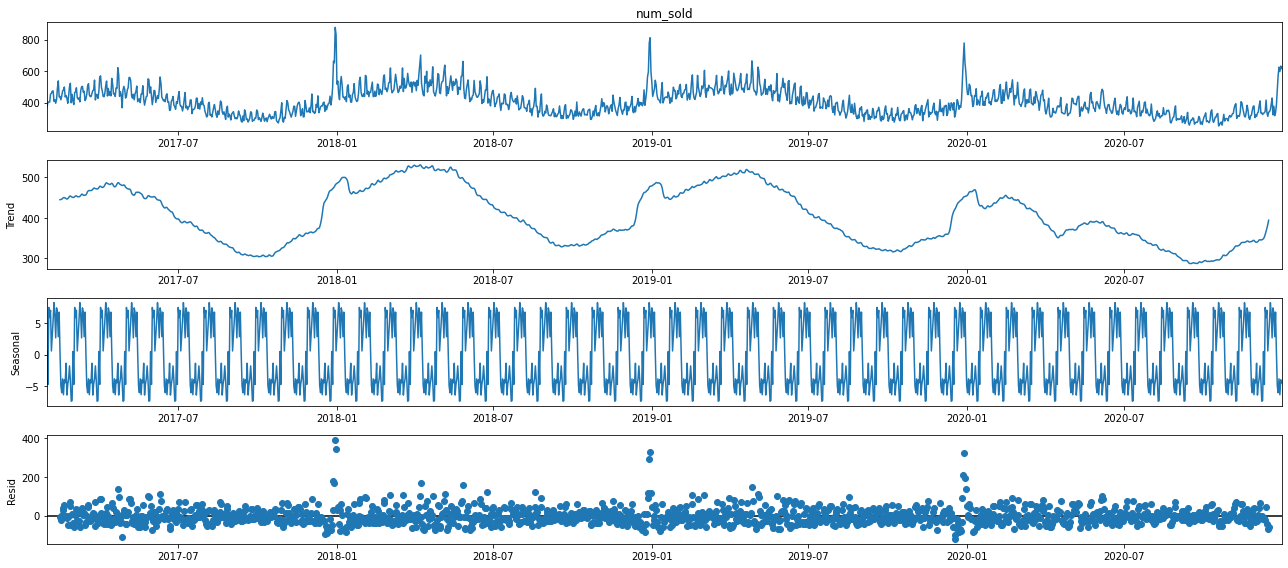

In [34]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period = 30)
fig = decomposition.plot()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14315D+00    |proj g|=  4.10370D-01


 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


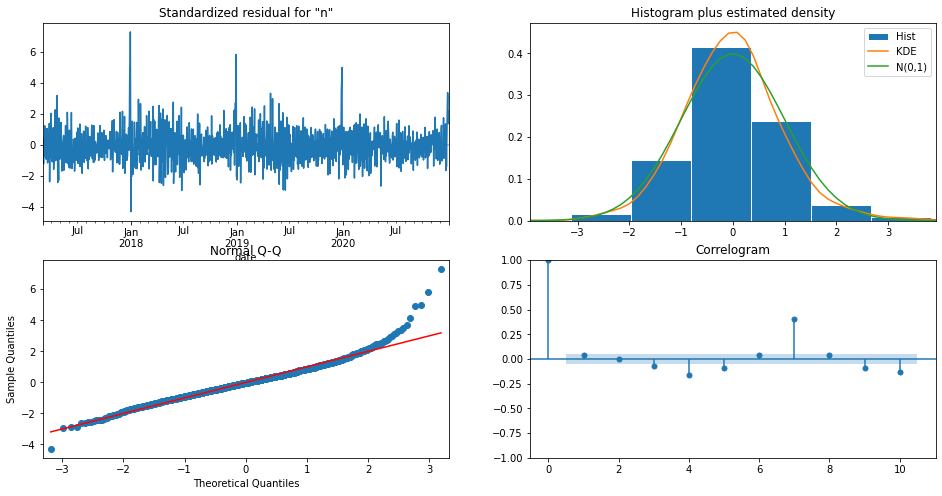

In [35]:
mod = SARIMAX(y,
              order=(1, 1, 1),
              seasonal_order=(1, 0, 1, 30),
              enforce_stationarity=False,
              enforce_invertibility=False,)
res = mod.fit()

res.plot_diagnostics(figsize=(16, 8))
plt.show()

In [59]:
start_forecast = 100
pred = res.get_prediction(start=start_forecast, dynamic=False)

In [43]:
pred = res.get_forecast(steps = 365)

In [44]:
pred.predicted_mean

2021-01-01    558.108571
2021-01-02    520.807686
2021-01-03    502.213115
2021-01-04    484.400667
2021-01-05    471.191867
                 ...    
2021-12-27    443.979995
2021-12-28    443.979995
2021-12-29    443.979995
2021-12-30    443.979995
2021-12-31    443.979995
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [38]:
len(test.date.unique())

365

In [62]:
test['num_sold'] = 0

In [63]:
test

,row_id,date,country,store,product,weekday,month,num_sold
0,70128,2021-01-01,Belgium,KaggleMart,A,4,1,0
1,70129,2021-01-01,Belgium,KaggleMart,B,4,1,0
2,70130,2021-01-01,Belgium,KaggleMart,C,4,1,0
3,70131,2021-01-01,Belgium,KaggleMart,D,4,1,0
4,70132,2021-01-01,Belgium,KaggleRama,A,4,1,0
...,...,...,...,...,...,...,...,...
17515,87643,2021-12-31,Spain,KaggleMart,D,4,12,0
17516,87644,2021-12-31,Spain,KaggleRama,A,4,12,0
17517,87645,2021-12-31,Spain,KaggleRama,B,4,12,0
17518,87646,2021-12-31,Spain,KaggleRama,C,4,12,0


In [68]:
def SARIMA_forecast(df):
    result_df = optimize_SARIMA(parameters_list, 1, 0, 30,df['num_sold'])
    p = result_df['params'].iloc[0]
    mod = SARIMAX(y,order=(p[0], 1, p[1]),
                seasonal_order=(p[2], 0, p[3], 30),
                enforce_stationarity=False,
                enforce_invertibility=False)
    res = mod.fit()
    pred = res.get_forecast(steps = 365)
    
    return pred.predicted_mean

for x in product(countries, stores, prods):
    print(x)
    df = train[(train['country'] == x[0]) & (train['store'] == x[1]) & (train['product'] == x[2])]
    df = df.set_index('date').asfreq('D')
    
    pred = SARIMA_forecast(df)
    
    new_index = test[(test['country'] == x[0]) & (test['store'] == x[1]) & (test['product'] == x[2])].index
    pred = pd.DataFrame(pred).set_index(new_index)
    
    if 'predicted_mean' in test.columns:
        test.loc[new_index,'predicted_mean'] = pred.loc[new_index,'predicted_mean']
    else:
        test = test.join(pred, how='left')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14315D+00    |proj g|=  4.10370D-01


 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14315D+00    |proj g|=  4.10370D-01


 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.05922D+00    |proj g|=  1.57450D-02

At iterate   10    f=  5.05877D+00    |proj g|=  2.12681D-02

At iterate   15    f=  5.05468D+00    |proj g|=  6.69339D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   4.609D-06   5.055D+00
  F =   5.0546488487017589     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14315D+00    |proj g|=  4.10370D-01


 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14315D+00    |proj g|=  4.10370D-01

At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14315D+00    |proj g|=  4.10370D-01

At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14315D+00    |proj g|=  4.10370D-01

At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14315D+00    |proj g|=  4.10370D-01

At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.06803D+00    |proj g|=  1.84778D-02

At iterate   10    f=  5.05915D+00    |proj g|=  6.26787D-02

At iterate   15    f=  5.05726D+00    |proj g|=  7.71277D-03

At iterate   20    f=  5.05393D+00    |proj g|=  7.35990D-02

At iterate   25    f=  5.05288D+00    |proj g|=  3.83586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.239D-05   5.053D+00
  F =   5.0528757685335650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [72]:
test[['row_id','predicted_mean']].rename(columns={'predicted_mean':'num_sold'}).set_index('row_id').to_csv('submission.csv')

In [70]:
df

,row_id,country,store,product,num_sold,weekday,month
date,,,,,,,
2017-01-01,47,Spain,KaggleRama,D,181,6,1
2017-01-02,95,Spain,KaggleRama,D,123,0,1
2017-01-03,143,Spain,KaggleRama,D,125,1,1
2017-01-04,191,Spain,KaggleRama,D,110,2,1
2017-01-05,239,Spain,KaggleRama,D,104,3,1
...,...,...,...,...,...,...,...
2020-12-27,69935,Spain,KaggleRama,D,204,6,12
2020-12-28,69983,Spain,KaggleRama,D,212,0,12
2020-12-29,70031,Spain,KaggleRama,D,242,1,12


In [ ]:
test

In [64]:
res = pd.DataFrame(pred.predicted_mean).set_index(new_index)

In [66]:
test.join(res, how='left')

,row_id,date,country,store,product,weekday,month,num_sold,predicted_mean
0,70128,2021-01-01,Belgium,KaggleMart,A,4,1,0,558.108571
1,70129,2021-01-01,Belgium,KaggleMart,B,4,1,0,NaN
2,70130,2021-01-01,Belgium,KaggleMart,C,4,1,0,NaN
3,70131,2021-01-01,Belgium,KaggleMart,D,4,1,0,NaN
4,70132,2021-01-01,Belgium,KaggleRama,A,4,1,0,NaN
...,...,...,...,...,...,...,...,...,...
17515,87643,2021-12-31,Spain,KaggleMart,D,4,12,0,NaN
17516,87644,2021-12-31,Spain,KaggleRama,A,4,12,0,NaN
17517,87645,2021-12-31,Spain,KaggleRama,B,4,12,0,NaN
17518,87646,2021-12-31,Spain,KaggleRama,C,4,12,0,NaN


In [56]:
new_index = test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'A')].index

In [60]:
new_index

Int64Index([    0,    48,    96,   144,   192,   240,   288,   336,   384,
              432,
            ...
            17040, 17088, 17136, 17184, 17232, 17280, 17328, 17376, 17424,
            17472],
           dtype='int64', length=365)

<AxesSubplot:>

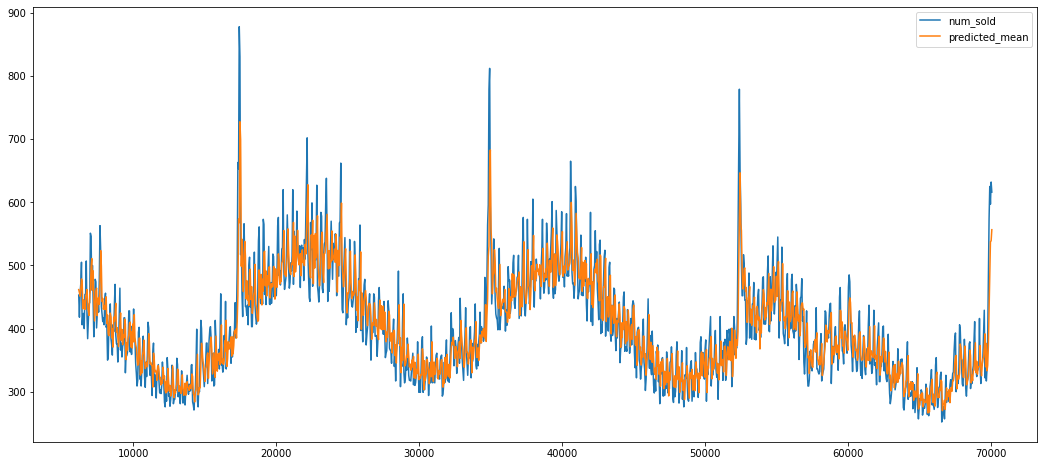

In [72]:
res_df = df.join(pred.predicted_mean, how='left')[['num_sold','predicted_mean']].dropna()
res_df.plot()

NameError: name 'train' is not defined

In [2]:
smape(res_df['num_sold'], res_df['predicted_mean'])

NameError: name 'smape' is not defined

In [74]:
F = res_df['predicted_mean'] 
A = res_df['num_sold']
100/res_df.shape[0] * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

7.631900136909902

In [80]:
(2 * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))) / res_df.shape[0]

0.07631900136909901